# This notebook seeks to Answer
* How do classifier (e.g.: linear probe) transfer between different types of attacks?

In [1]:
from pathlib import Path
import os
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
project_root = notebook_dir
os.chdir(project_root)
project_root


PosixPath('/data/nathalie_maria_kirch/ERA_Fellowship')

In [2]:
import pandas as pd
import sys
import os
import numpy as np
from pathlib import Path

In [3]:
from analysis.unsupervised import *
from analysis.supervised import *

In [36]:
## Load rated dataset 
wild_jailbreak_path = project_root/ "datasets/latest/wildJailBreak_rated.pkl"

wei_gemma7bit = project_root / "datasets/latest/gemma-7b-it_wei_three_new_rated_merged.pkl"

wei_llama8bit = project_root / "datasets/_meta-llamaLlama-3.1-8B-Instruct_prompt_res_activations_2911202410:07:48_rated.pkl"
wei_llama_3bit = project_root / "datasets/_meta-llamaLlama-3.2-3B-Instruct_prompt_res_activations_3011202404:14:34_rated.pkl"

wei_mistral8bit = project_root / "datasets/_mistralaiMinistral-8B-Instruct-2410_prompt_res_activations_0501202507:39:16_rated.pkl"


path = [wild_jailbreak_path, wei_gemma7bit, wei_llama8bit, wei_llama_3bit, wei_mistral8bit][4]

df = pd.read_pickle(path)

path = str(path)

In [37]:
from analysis.models import * 

model_name, num_layers, rating_column, hf_ident, input_size = get_model_details(path)

layer= num_layers - 4

# layer = 17
activation_column="prompt_res_activations"
num_samples = len(df)
dataset_name = "wildJailBreak" if "wildJailBreak" in str(path) else "wei_dataset"

In [38]:
if "gemma" in model_name: 
  df = df[~df["jailbreak_prompt_name"].isin(["auto_payload_splitting", "auto_obfuscation", "dev_mode_with_rant", "none"])]
else: 
  df = df[~df["jailbreak_prompt_name"].isin(["auto_payload_splitting", "auto_obfuscation", "dev_mode_with_rant", "none", "gcg", "autodan"])]

In [39]:
# # PERCENTILE CUTOFF
# rating_column = ["rating", "rating_output_text"][1]
# # Calculate ASR for each jailbreak_prompt_name
# asr_values = []

# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     # Calculate normalized value counts for each prompt
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
#         asr_values.append(ASR["Yes"])

# # Calculate the 90th percentile cutoff
# percentile = 50
# percentile_cutoff = np.percentile(asr_values, percentile)
# print(f"{percentile}th Percentile Cutoff for ASR: {percentile_cutoff}")

# # Collect successful jailbreak_prompt_names above the 90th percentile
# successful_jailbreaks = []

# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     # Check conditions: ASR["Yes"] exists and exceeds the 90th percentile
#     if "Yes" in ASR and ASR["Yes"] > percentile_cutoff:
#         successful_jailbreaks.append(jailbreak_prompt)

# # Filter the dataframe to keep only rows matching the criteria or the 'original_prompt'
# df = df[(df['jailbreak_prompt_name'].isin(successful_jailbreaks)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# # Display the count of remaining jailbreak_prompt_name values
# print(df["jailbreak_prompt_name"].value_counts())


In [40]:
# ## TOP 10 JAILBREAK PROMPTS
# import numpy as np

# # Calculate ASR (Accuracy Success Rate) for each jailbreak_prompt_name
# asr_values = []

# # Calculate the ASR for each jailbreak prompt
# for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
#     # Calculate normalized value counts for each prompt
#     ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
#     if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
#         asr_values.append((jailbreak_prompt, ASR["Yes"]))

# # Sort the ASR values in descending order and select the top 10
# top_10_jailbreaks = sorted(asr_values, key=lambda x: x[1], reverse=True)[:10]

# # Extract the top 10 jailbreak prompt names
# top_10_jailbreak_prompt_names = [item[0] for item in top_10_jailbreaks]

# # Filter the dataframe to keep only rows matching the top 10 jailbreak prompts or the 'original_prompt'
# df = df[(df['jailbreak_prompt_name'].isin(top_10_jailbreak_prompt_names)) | (df['jailbreak_prompt_name'] == 'original_prompt')]

# # Display the count of remaining jailbreak_prompt_name values
# print(df["jailbreak_prompt_name"].value_counts())

In [41]:
asr_values = []

# Calculate ASR (Accuracy Success Rate) for each jailbreak prompt
for jailbreak_prompt in df['jailbreak_prompt_name'].unique():
        # Calculate normalized value counts for each prompt
        ASR = df[df['jailbreak_prompt_name'] == jailbreak_prompt][rating_column].value_counts(normalize=True)
        if "Yes" in ASR:  # Only consider prompts with "Yes" success rates
            asr_values.append((jailbreak_prompt, ASR["Yes"]))

# Sort the ASR values in descending order and select the top 10
top_10_jailbreaks = sorted(asr_values, key=lambda x: x[1], reverse=True)[:10]
    
# Extract the top 10 jailbreak prompt names
top_10_jailbreak_prompt_names = [item[0] for item in top_10_jailbreaks]

# Filter the dataframe to keep only rows matching the top 10 jailbreak prompts or the 'original_prompt'
df = df[(df['jailbreak_prompt_name'].isin(top_10_jailbreak_prompt_names)) | 
            (df['jailbreak_prompt_name'] == 'original_prompt')]


# Display the count of remaining jailbreak_prompt_name values
print(df["jailbreak_prompt_name"].value_counts())


jailbreak_prompt_name
original_prompt           600
base64_output_only        300
evil_system_prompt        300
wikipedia                 300
prefix_injection_hello    300
style_injection_json      300
distractors_negated       300
prefix_injection          300
wikipedia_with_title      300
multi_shot_25             300
Name: count, dtype: int64


## Linear Probe

In [42]:
def extract_layer(row, layer):
    return row['prompt_res_activations'][layer][0].cpu().numpy().flatten()

In [43]:
# Add column that has 0 if "rating" is "No" and 1 if "rating" is "Yes"
df['rating_binary'] = df[rating_column].apply(lambda x: 0 if x == "No" else 1)

# Create new columns for each layer
df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)


## Transfer with Holdout

In [52]:
# Calculate the layers of interest
layers = range(0, num_layers)

holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "logistic_regression", layers = layers)


len df wo holdout:  2700 len df w holdout:  600
Holdout:  original_prompt
len train data:  1744 len test data:  436


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

600
eval fn
0.8333333333333334
Test Accuracy without holdout: 0.7247706422018348, SE: 0.02138968704624218
Test Accuracy with holdout: 0.8333333333333334, SE: 0.015214515486254613
len df wo holdout:  3000 len df w holdout:  300
Holdout:  base64_output_only
len train data:  1856 len test data:  464


/data/nathalie_maria_kirch/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kir

300
eval fn
0.6166666666666667
Test Accuracy without holdout: 0.7844827586206896, SE: 0.019088584332701136
Test Accuracy with holdout: 0.6166666666666667, SE: 0.028070677992577286
len df wo holdout:  3000 len df w holdout:  300
Holdout:  evil_system_prompt
len train data:  1918 len test data:  480


/data/nathalie_maria_kirch/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kir

300
eval fn
0.8833333333333333
Test Accuracy without holdout: 0.7395833333333334, SE: 0.020031216595858204
Test Accuracy with holdout: 0.8833333333333333, SE: 0.018534252575124754
len df wo holdout:  3000 len df w holdout:  300
Holdout:  wikipedia
len train data:  1873 len test data:  469


/data/nathalie_maria_kirch/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kir

300
eval fn
0.6166666666666667
Test Accuracy without holdout: 0.7654584221748401, SE: 0.01956520049905218
Test Accuracy with holdout: 0.6166666666666667, SE: 0.028070677992577286
len df wo holdout:  3000 len df w holdout:  300
Holdout:  prefix_injection_hello
len train data:  1883 len test data:  471


/data/nathalie_maria_kirch/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kir

300
eval fn
0.5633333333333334
Test Accuracy without holdout: 0.732484076433121, SE: 0.020396866782253373
Test Accuracy with holdout: 0.5633333333333334, SE: 0.028634995424531903
len df wo holdout:  3000 len df w holdout:  300
Holdout:  style_injection_json
len train data:  1836 len test data:  460


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
eval fn
0.4666666666666667
Test Accuracy without holdout: 0.7521739130434782, SE: 0.02013046132111084
Test Accuracy with holdout: 0.4666666666666667, SE: 0.02880329199292382
len df wo holdout:  3000 len df w holdout:  300
Holdout:  distractors_negated
len train data:  1918 len test data:  480


/data/nathalie_maria_kirch/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kir

300
eval fn
0.6366666666666667
Test Accuracy without holdout: 0.7541666666666667, SE: 0.019653207199862844
Test Accuracy with holdout: 0.6366666666666667, SE: 0.02776822057810104
len df wo holdout:  3000 len df w holdout:  300
Holdout:  prefix_injection
len train data:  2062 len test data:  516


/data/nathalie_maria_kirch/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kir

300
eval fn
0.8066666666666666
Test Accuracy without holdout: 0.7344961240310077, SE: 0.019440406245477836
Test Accuracy with holdout: 0.8066666666666666, SE: 0.022800259907550437
len df wo holdout:  3000 len df w holdout:  300
Holdout:  wikipedia_with_title
len train data:  1835 len test data:  459


/data/nathalie_maria_kirch/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kir

300
eval fn
0.6466666666666666
Test Accuracy without holdout: 0.7886710239651417, SE: 0.019055534018714366
Test Accuracy with holdout: 0.6466666666666666, SE: 0.02759763811686844
len df wo holdout:  3000 len df w holdout:  300
Holdout:  multi_shot_25
len train data:  1907 len test data:  477


/data/nathalie_maria_kirch/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kir

300
eval fn
0.6366666666666667
Test Accuracy without holdout: 0.7631027253668763, SE: 0.019467596896902757
Test Accuracy with holdout: 0.6366666666666667, SE: 0.02776822057810104


In [53]:
holdout_df

,test accuracy w/o holdout var,test accuracy SE w/o holdout var,test size w/o holdout var,test accuracy w holdout var,test accuracy SE w holdout var,test size w holdout var
original_prompt,0.724771,0.02139,436,0.833333,0.015215,600
base64_output_only,0.784483,0.019089,464,0.616667,0.028071,300
evil_system_prompt,0.739583,0.020031,480,0.883333,0.018534,300
wikipedia,0.765458,0.019565,469,0.616667,0.028071,300
prefix_injection_hello,0.732484,0.020397,471,0.563333,0.028635,300
style_injection_json,0.752174,0.02013,460,0.466667,0.028803,300
distractors_negated,0.754167,0.019653,480,0.636667,0.027768,300
prefix_injection,0.734496,0.01944,516,0.806667,0.0228,300
wikipedia_with_title,0.788671,0.019056,459,0.646667,0.027598,300
multi_shot_25,0.763103,0.019468,477,0.636667,0.027768,300


In [54]:
print('test accuracy w holdout var' in holdout_df.columns)
print('test accuracy w/o holdout var' in holdout_df.columns)


True
True


In [55]:
mean_transfer = round(holdout_df["test accuracy w holdout var"].mean(),2)

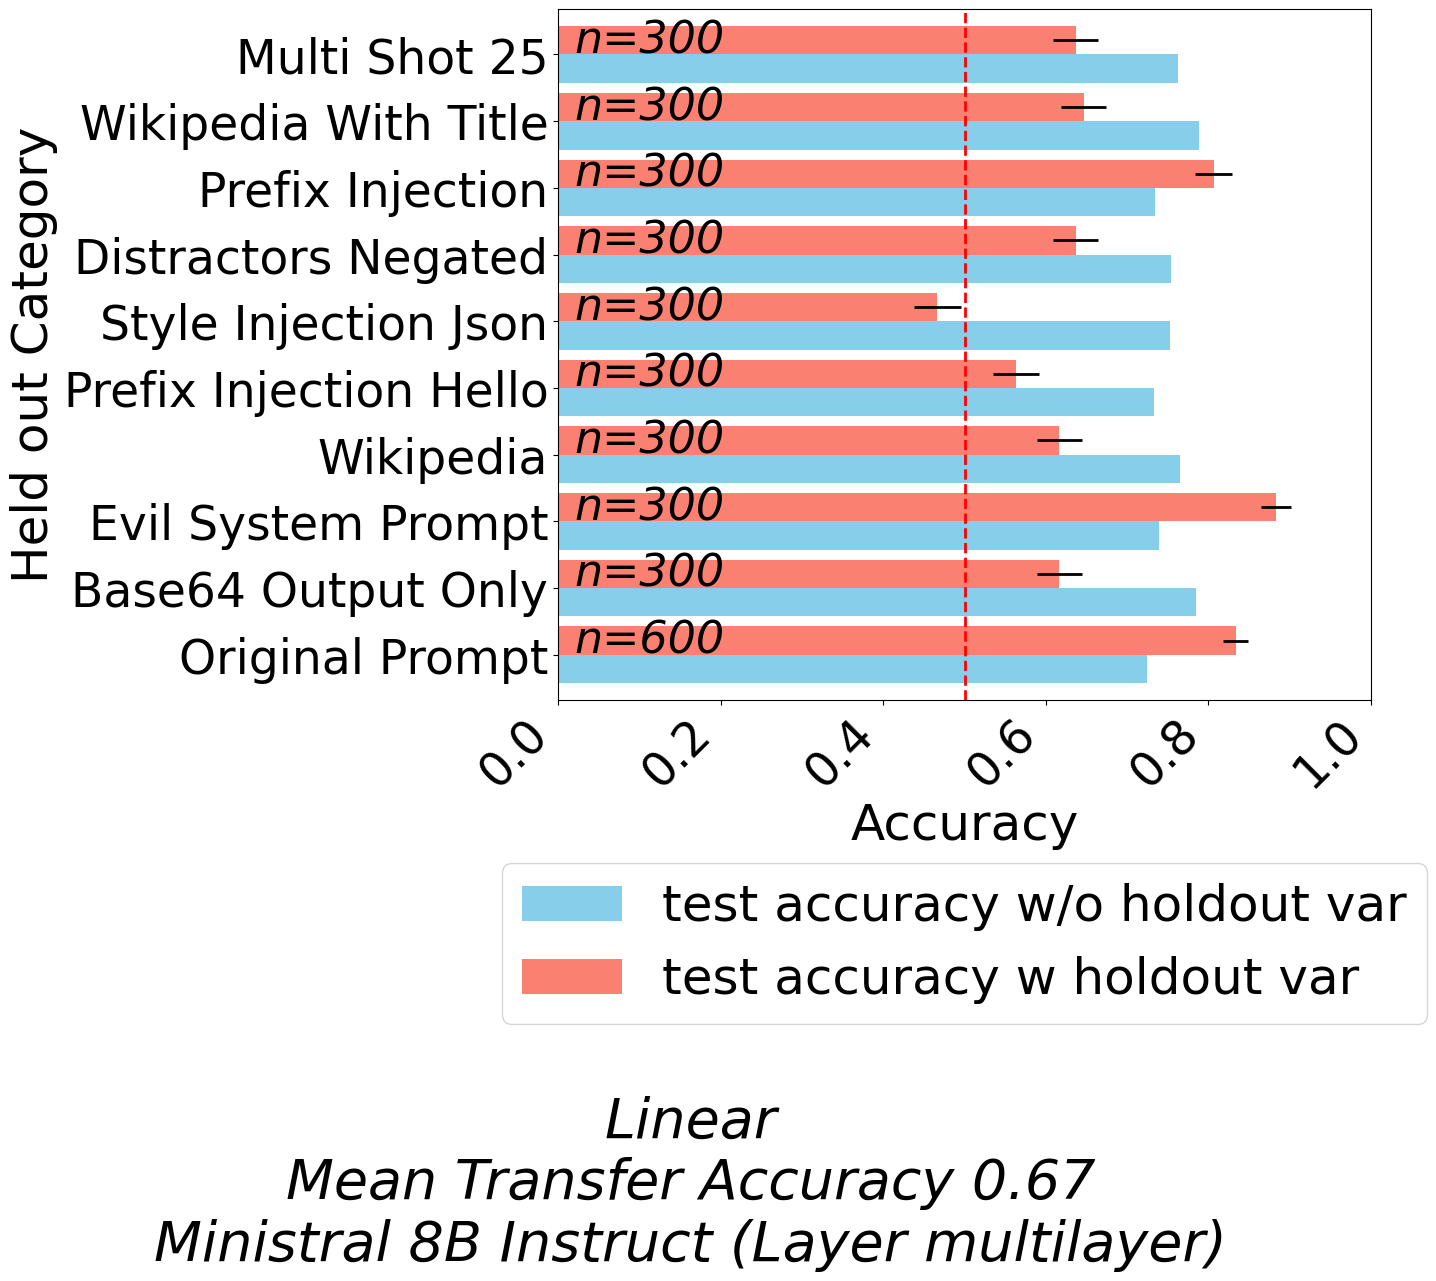

In [56]:
if len(layers) > 1: layer = "multilayer"

holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Linear", mean_tranfer_score=mean_transfer, savepath= project_root / f"images/transfer/{model_name}/{dataset_name}_{model_name}_layer_{layer}_linear_holdout.pdf")

## MLP Probe

In [57]:
from analysis.supervised import *

## Transfer with Holdout

In [60]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "MLP", layers = layers, input_size = input_size)


len df wo holdout:  2700 len df w holdout:  600
Holdout:  original_prompt


len train data:  1744 len test data:  436
Epoch [10/500], Loss: 0.6613
Epoch [20/500], Loss: 0.6432
Epoch [30/500], Loss: 0.6291
Epoch [40/500], Loss: 0.6171
Epoch [50/500], Loss: 0.6064
Epoch [60/500], Loss: 0.5968
Epoch [70/500], Loss: 0.5881
Epoch [80/500], Loss: 0.5802
Epoch [90/500], Loss: 0.5732
Epoch [100/500], Loss: 0.5669
Epoch [110/500], Loss: 0.5611
Epoch [120/500], Loss: 0.5558
Epoch [130/500], Loss: 0.5509
Epoch [140/500], Loss: 0.5462
Epoch [150/500], Loss: 0.5419
Epoch [160/500], Loss: 0.5377
Epoch [170/500], Loss: 0.5337
Epoch [180/500], Loss: 0.5299
Epoch [190/500], Loss: 0.5261
Epoch [200/500], Loss: 0.5225
Epoch [210/500], Loss: 0.5189
Epoch [220/500], Loss: 0.5153
Epoch [230/500], Loss: 0.5118
Epoch [240/500], Loss: 0.5083
Epoch [250/500], Loss: 0.5048
Epoch [260/500], Loss: 0.5014
Epoch [270/500], Loss: 0.4980
Epoch [280/500], Loss: 0.4946
Epoch [290/500], Loss: 0.4914
Epoch [300/500], Loss: 0.4882
Epoch [310/500], Loss: 0.4851
Epoch [320/500], Loss: 0.4822
Epoch [

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

600
600 600
600 600
Test Accuracy without holdout: 0.6788990825688074, SE: 0.022360429408657137
Test Accuracy with holdout: 0.7433333333333333, SE: 0.017832035259091474
len df wo holdout:  3000 len df w holdout:  300
Holdout:  base64_output_only
len train data:  1856 len test data:  464
Epoch [10/500], Loss: 0.6651
Epoch [20/500], Loss: 0.6423
Epoch [30/500], Loss: 0.6251
Epoch [40/500], Loss: 0.6108
Epoch [50/500], Loss: 0.5985
Epoch [60/500], Loss: 0.5879
Epoch [70/500], Loss: 0.5787
Epoch [80/500], Loss: 0.5705
Epoch [90/500], Loss: 0.5632
Epoch [100/500], Loss: 0.5566
Epoch [110/500], Loss: 0.5507
Epoch [120/500], Loss: 0.5450
Epoch [130/500], Loss: 0.5396
Epoch [140/500], Loss: 0.5345
Epoch [150/500], Loss: 0.5298
Epoch [160/500], Loss: 0.5252
Epoch [170/500], Loss: 0.5208
Epoch [180/500], Loss: 0.5166
Epoch [190/500], Loss: 0.5125
Epoch [200/500], Loss: 0.5085
Epoch [210/500], Loss: 0.5047
Epoch [220/500], Loss: 0.5009
Epoch [230/500], Loss: 0.4973
Epoch [240/500], Loss: 0.4938
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.7521551724137931, SE: 0.020044012403794567
Test Accuracy with holdout: 0.6333333333333333, SE: 0.02782218672344203
len df wo holdout:  3000 len df w holdout:  300
Holdout:  evil_system_prompt
len train data:  1918 len test data:  480
Epoch [10/500], Loss: 0.6615
Epoch [20/500], Loss: 0.6403
Epoch [30/500], Loss: 0.6237
Epoch [40/500], Loss: 0.6099
Epoch [50/500], Loss: 0.5979
Epoch [60/500], Loss: 0.5873
Epoch [70/500], Loss: 0.5779
Epoch [80/500], Loss: 0.5694
Epoch [90/500], Loss: 0.5619
Epoch [100/500], Loss: 0.5551
Epoch [110/500], Loss: 0.5489
Epoch [120/500], Loss: 0.5431
Epoch [130/500], Loss: 0.5377
Epoch [140/500], Loss: 0.5327
Epoch [150/500], Loss: 0.5280
Epoch [160/500], Loss: 0.5235
Epoch [170/500], Loss: 0.5192
Epoch [180/500], Loss: 0.5150
Epoch [190/500], Loss: 0.5109
Epoch [200/500], Loss: 0.5070
Epoch [210/500], Loss: 0.5033
Epoch [220/500], Loss: 0.4996
Epoch [230/500], Loss: 0.4961
Epoch [240/500], Loss: 0.4926
Ep

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.6979166666666666, SE: 0.020957744842080236
Test Accuracy with holdout: 0.8166666666666667, SE: 0.02233996584764789
len df wo holdout:  3000 len df w holdout:  300
Holdout:  wikipedia
len train data:  1873 len test data:  469
Epoch [10/500], Loss: 0.6712
Epoch [20/500], Loss: 0.6454
Epoch [30/500], Loss: 0.6290
Epoch [40/500], Loss: 0.6163
Epoch [50/500], Loss: 0.6049
Epoch [60/500], Loss: 0.5948
Epoch [70/500], Loss: 0.5853
Epoch [80/500], Loss: 0.5769
Epoch [90/500], Loss: 0.5696
Epoch [100/500], Loss: 0.5629
Epoch [110/500], Loss: 0.5565
Epoch [120/500], Loss: 0.5504
Epoch [130/500], Loss: 0.5445
Epoch [140/500], Loss: 0.5388
Epoch [150/500], Loss: 0.5331
Epoch [160/500], Loss: 0.5274
Epoch [170/500], Loss: 0.5218
Epoch [180/500], Loss: 0.5164
Epoch [190/500], Loss: 0.5112
Epoch [200/500], Loss: 0.5060
Epoch [210/500], Loss: 0.5009
Epoch [220/500], Loss: 0.4959
Epoch [230/500], Loss: 0.4911
Epoch [240/500], Loss: 0.4864
Epoch [250/

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.7398720682302772, SE: 0.02025747859391172
Test Accuracy with holdout: 0.63, SE: 0.027874719729532708
len df wo holdout:  3000 len df w holdout:  300
Holdout:  prefix_injection_hello
len train data:  1883 len test data:  471
Epoch [10/500], Loss: 0.6500
Epoch [20/500], Loss: 0.6307
Epoch [30/500], Loss: 0.6155
Epoch [40/500], Loss: 0.6029
Epoch [50/500], Loss: 0.5919
Epoch [60/500], Loss: 0.5817
Epoch [70/500], Loss: 0.5721
Epoch [80/500], Loss: 0.5632
Epoch [90/500], Loss: 0.5548
Epoch [100/500], Loss: 0.5467
Epoch [110/500], Loss: 0.5397
Epoch [120/500], Loss: 0.5334
Epoch [130/500], Loss: 0.5275
Epoch [140/500], Loss: 0.5220
Epoch [150/500], Loss: 0.5167
Epoch [160/500], Loss: 0.5116
Epoch [170/500], Loss: 0.5069
Epoch [180/500], Loss: 0.5023
Epoch [190/500], Loss: 0.4980
Epoch [200/500], Loss: 0.4938
Epoch [210/500], Loss: 0.4898
Epoch [220/500], Loss: 0.4859
Epoch [230/500], Loss: 0.4821
Epoch [240/500], Loss: 0.4785
Epoch [250/5

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.7558386411889597, SE: 0.01979440986060164
Test Accuracy with holdout: 0.5633333333333334, SE: 0.028634995424531903
len df wo holdout:  3000 len df w holdout:  300
Holdout:  style_injection_json
len train data:  1836 len test data:  460
Epoch [10/500], Loss: 0.6329
Epoch [20/500], Loss: 0.5923
Epoch [30/500], Loss: 0.5661
Epoch [40/500], Loss: 0.5478
Epoch [50/500], Loss: 0.5339
Epoch [60/500], Loss: 0.5224
Epoch [70/500], Loss: 0.5127
Epoch [80/500], Loss: 0.5042
Epoch [90/500], Loss: 0.4966
Epoch [100/500], Loss: 0.4896
Epoch [110/500], Loss: 0.4832
Epoch [120/500], Loss: 0.4772
Epoch [130/500], Loss: 0.4715
Epoch [140/500], Loss: 0.4661
Epoch [150/500], Loss: 0.4609
Epoch [160/500], Loss: 0.4559
Epoch [170/500], Loss: 0.4511
Epoch [180/500], Loss: 0.4466
Epoch [190/500], Loss: 0.4421
Epoch [200/500], Loss: 0.4379
Epoch [210/500], Loss: 0.4337
Epoch [220/500], Loss: 0.4297
Epoch [230/500], Loss: 0.4258
Epoch [240/500], Loss: 0.4220


/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.7630434782608696, SE: 0.019825769821361697
Test Accuracy with holdout: 0.4666666666666667, SE: 0.02880329199292382
len df wo holdout:  3000 len df w holdout:  300
Holdout:  distractors_negated
len train data:  1918 len test data:  480
Epoch [10/500], Loss: 0.6505
Epoch [20/500], Loss: 0.6282
Epoch [30/500], Loss: 0.6145
Epoch [40/500], Loss: 0.6045
Epoch [50/500], Loss: 0.5965
Epoch [60/500], Loss: 0.5893
Epoch [70/500], Loss: 0.5828
Epoch [80/500], Loss: 0.5764
Epoch [90/500], Loss: 0.5703
Epoch [100/500], Loss: 0.5645
Epoch [110/500], Loss: 0.5588
Epoch [120/500], Loss: 0.5534
Epoch [130/500], Loss: 0.5481
Epoch [140/500], Loss: 0.5431
Epoch [150/500], Loss: 0.5382
Epoch [160/500], Loss: 0.5335
Epoch [170/500], Loss: 0.5289
Epoch [180/500], Loss: 0.5245
Epoch [190/500], Loss: 0.5203
Epoch [200/500], Loss: 0.5161
Epoch [210/500], Loss: 0.5121
Epoch [220/500], Loss: 0.5082
Epoch [230/500], Loss: 0.5044
Epoch [240/500], Loss: 0.5007
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.7645833333333333, SE: 0.01936468325985813
Test Accuracy with holdout: 0.5533333333333333, SE: 0.02870281958017107
len df wo holdout:  3000 len df w holdout:  300
Holdout:  prefix_injection
len train data:  2062 len test data:  516
Epoch [10/500], Loss: 0.6600
Epoch [20/500], Loss: 0.6334
Epoch [30/500], Loss: 0.6153
Epoch [40/500], Loss: 0.6015
Epoch [50/500], Loss: 0.5903
Epoch [60/500], Loss: 0.5809
Epoch [70/500], Loss: 0.5728
Epoch [80/500], Loss: 0.5654
Epoch [90/500], Loss: 0.5587
Epoch [100/500], Loss: 0.5525
Epoch [110/500], Loss: 0.5466
Epoch [120/500], Loss: 0.5412
Epoch [130/500], Loss: 0.5361
Epoch [140/500], Loss: 0.5313
Epoch [150/500], Loss: 0.5267
Epoch [160/500], Loss: 0.5222
Epoch [170/500], Loss: 0.5179
Epoch [180/500], Loss: 0.5137
Epoch [190/500], Loss: 0.5096
Epoch [200/500], Loss: 0.5056
Epoch [210/500], Loss: 0.5017
Epoch [220/500], Loss: 0.4980
Epoch [230/500], Loss: 0.4943
Epoch [240/500], Loss: 0.4908
Epoch

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.7151162790697675, SE: 0.0198699739624823
Test Accuracy with holdout: 0.9033333333333333, SE: 0.017060893120645067
len df wo holdout:  3000 len df w holdout:  300
Holdout:  wikipedia_with_title
len train data:  1835 len test data:  459
Epoch [10/500], Loss: 0.6522
Epoch [20/500], Loss: 0.6284
Epoch [30/500], Loss: 0.6130
Epoch [40/500], Loss: 0.6019
Epoch [50/500], Loss: 0.5931
Epoch [60/500], Loss: 0.5857
Epoch [70/500], Loss: 0.5792
Epoch [80/500], Loss: 0.5733
Epoch [90/500], Loss: 0.5675
Epoch [100/500], Loss: 0.5618
Epoch [110/500], Loss: 0.5562
Epoch [120/500], Loss: 0.5507
Epoch [130/500], Loss: 0.5455
Epoch [140/500], Loss: 0.5403
Epoch [150/500], Loss: 0.5351
Epoch [160/500], Loss: 0.5299
Epoch [170/500], Loss: 0.5247
Epoch [180/500], Loss: 0.5194
Epoch [190/500], Loss: 0.5144
Epoch [200/500], Loss: 0.5097
Epoch [210/500], Loss: 0.5052
Epoch [220/500], Loss: 0.5008
Epoch [230/500], Loss: 0.4964
Epoch [240/500], Loss: 0.4920
E

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.738562091503268, SE: 0.02051027313119721
Test Accuracy with holdout: 0.6133333333333333, SE: 0.028116161162550595
len df wo holdout:  3000 len df w holdout:  300
Holdout:  multi_shot_25
len train data:  1907 len test data:  477
Epoch [10/500], Loss: 0.6565
Epoch [20/500], Loss: 0.6382
Epoch [30/500], Loss: 0.6252
Epoch [40/500], Loss: 0.6144
Epoch [50/500], Loss: 0.6046
Epoch [60/500], Loss: 0.5956
Epoch [70/500], Loss: 0.5873
Epoch [80/500], Loss: 0.5794
Epoch [90/500], Loss: 0.5719
Epoch [100/500], Loss: 0.5650
Epoch [110/500], Loss: 0.5583
Epoch [120/500], Loss: 0.5521
Epoch [130/500], Loss: 0.5462
Epoch [140/500], Loss: 0.5406
Epoch [150/500], Loss: 0.5353
Epoch [160/500], Loss: 0.5302
Epoch [170/500], Loss: 0.5253
Epoch [180/500], Loss: 0.5207
Epoch [190/500], Loss: 0.5164
Epoch [200/500], Loss: 0.5121
Epoch [210/500], Loss: 0.5081
Epoch [220/500], Loss: 0.5042
Epoch [230/500], Loss: 0.5004
Epoch [240/500], Loss: 0.4967
Epoch [2

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
300 300
300 300
Test Accuracy without holdout: 0.7190775681341719, SE: 0.020578887388884675
Test Accuracy with holdout: 0.71, SE: 0.026197964297504747


In [61]:
holdout_df

,test accuracy w/o holdout var,test accuracy SE w/o holdout var,test size w/o holdout var,test accuracy w holdout var,test accuracy SE w holdout var,test size w holdout var
original_prompt,0.678899,0.02236,436,0.743333,0.017832,600
base64_output_only,0.752155,0.020044,464,0.633333,0.027822,300
evil_system_prompt,0.697917,0.020958,480,0.816667,0.02234,300
wikipedia,0.739872,0.020257,469,0.63,0.027875,300
prefix_injection_hello,0.755839,0.019794,471,0.563333,0.028635,300
style_injection_json,0.763043,0.019826,460,0.466667,0.028803,300
distractors_negated,0.764583,0.019365,480,0.553333,0.028703,300
prefix_injection,0.715116,0.01987,516,0.903333,0.017061,300
wikipedia_with_title,0.738562,0.02051,459,0.613333,0.028116,300
multi_shot_25,0.719078,0.020579,477,0.71,0.026198,300


In [62]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["test accuracy w holdout var"].mean(),2)

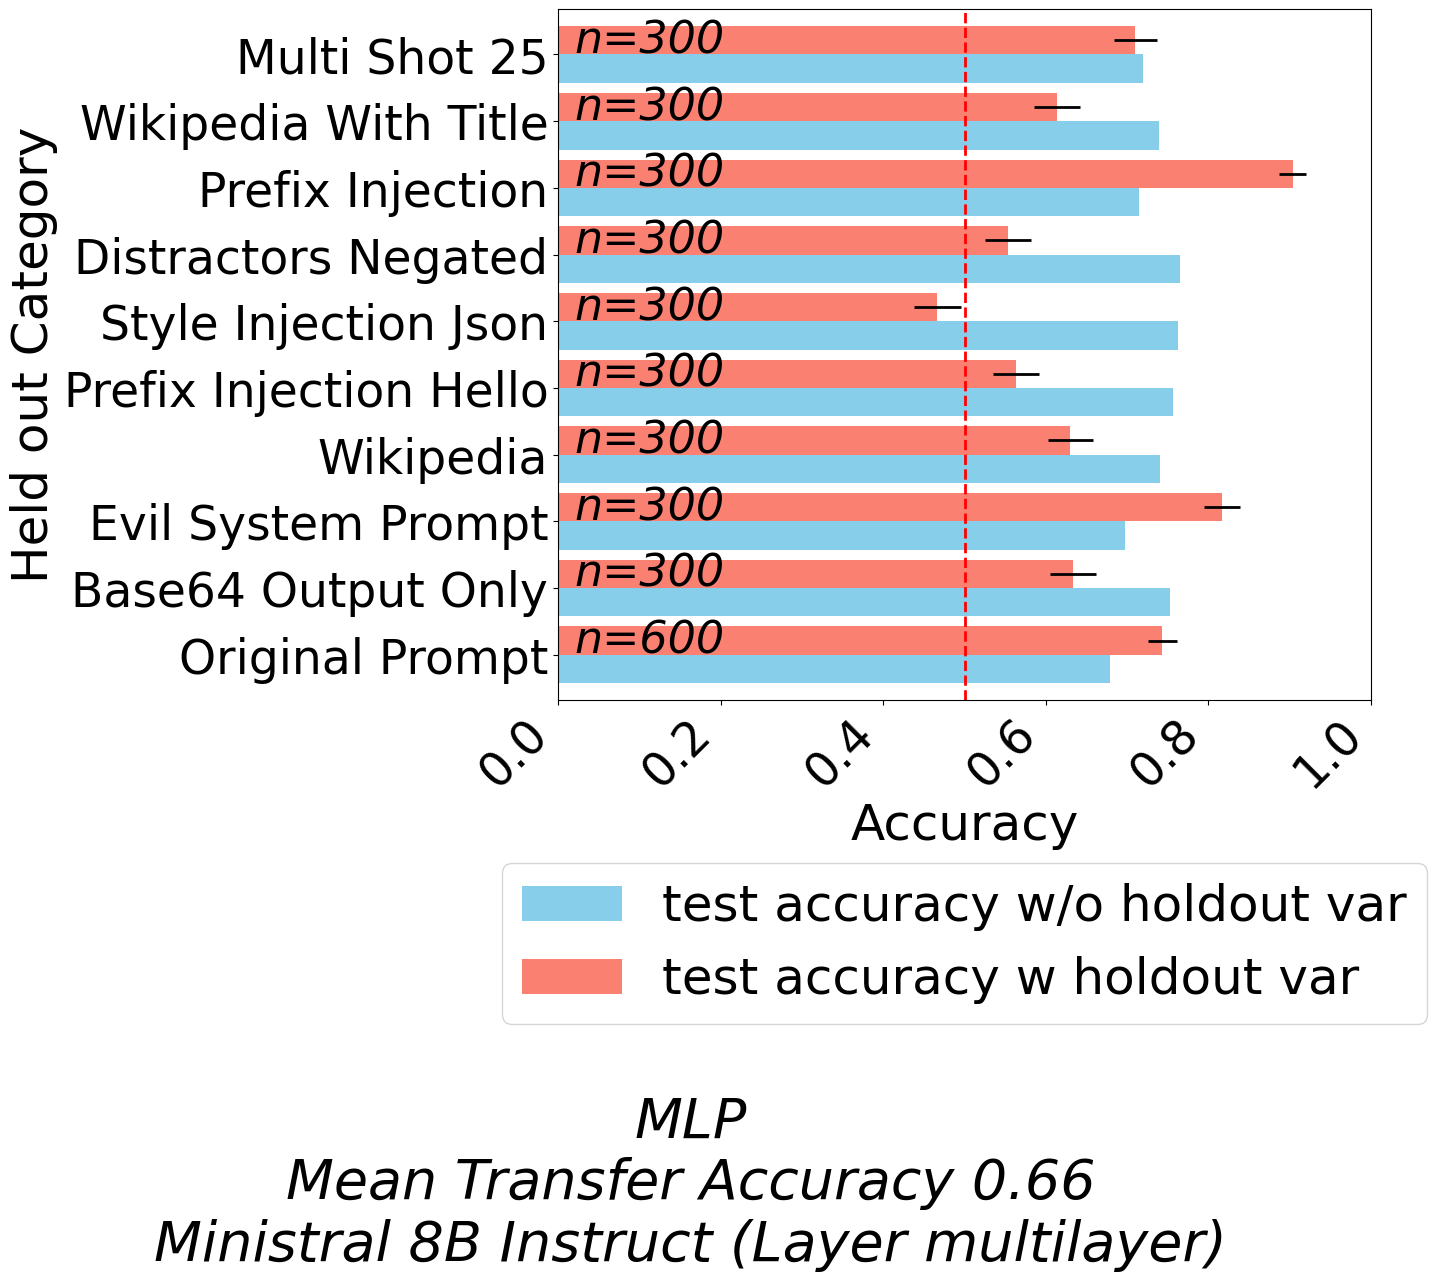

In [63]:
if len(layers) > 1: layer = "multilayer"

plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "MLP", mean_tranfer_score= mean_transfer, savepath= project_root / f"images/transfer/{model_name}/{dataset_name}_{model_name}_layer_{layer}_MLP_holdout.pdf")

# Transformer probe

In [64]:
holdout_df = transfer_with_holdout_with_errors(df = df, probe_type = "transformer", layers = layers, input_size = input_size)


len df wo holdout:  2700 len df w holdout:  600
Holdout:  original_prompt


len train data:  1744 len test data:  436
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1744, 4096])
y_train shape: torch.Size([1744])
Epoch [10/500], Loss: 0.7029, Accuracy: 0.4633
Epoch [20/500], Loss: 0.6359, Accuracy: 0.6451
Epoch [30/500], Loss: 0.5955, Accuracy: 0.6823
Epoch [40/500], Loss: 0.5367, Accuracy: 0.7294
Epoch [50/500], Loss: 0.4849, Accuracy: 0.7792
Epoch [60/500], Loss: 0.4374, Accuracy: 0.8022
Epoch [70/500], Loss: 0.4523, Accuracy: 0.7959
Epoch [80/500], Loss: 0.4463, Accuracy: 0.8326
Epoch [90/500], Loss: 0.3786, Accuracy: 0.8366
Epoch [100/500], Loss: 0.3212, Accuracy: 0.8727
Epoch [110/500], Loss: 0.3100, Accuracy: 0.8635
Epoch [120/500], Loss: 0.2913, Accuracy: 0.8796
Epoch [130/500], Loss: 0.2838, Accuracy: 0.8899
Epoch [140/500], Loss: 0.2533, Accuracy: 0.8773
Epoch [150/500], Loss: 0.2332, Accuracy: 0.8882
Epoch [160/500], Loss: 0.2618, Accuracy: 0.8859
Epoch [170/500], Loss: 0.2810, Accuracy: 0.8802
Epoch [180/500],

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

600
Accuracy: 0.8300

Confusion Matrix:
[[180  38]
 [ 64 318]]
Test Accuracy without holdout: 0.7178899082568807, SE: 0.021552367836443355
Test Accuracy with holdout: 0.83, SE: 0.01533514482053126
len df wo holdout:  3000 len df w holdout:  300
Holdout:  base64_output_only
len train data:  1856 len test data:  464
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1856, 4096])
y_train shape: torch.Size([1856])
Epoch [10/500], Loss: 0.6959, Accuracy: 0.5889
Epoch [20/500], Loss: 0.5801, Accuracy: 0.7053
Epoch [30/500], Loss: 0.5039, Accuracy: 0.7478
Epoch [40/500], Loss: 0.4633, Accuracy: 0.7608
Epoch [50/500], Loss: 0.4123, Accuracy: 0.7926
Epoch [60/500], Loss: 0.3410, Accuracy: 0.8448
Epoch [70/500], Loss: 0.3044, Accuracy: 0.8524
Epoch [80/500], Loss: 0.4446, Accuracy: 0.7602
Epoch [90/500], Loss: 0.3554, Accuracy: 0.8184
Epoch [100/500], Loss: 0.3082, Accuracy: 0.8637
Epoch [110/500], Loss: 0.3276, Accuracy: 0.8567
Epoch [120/500], Loss: 0.2342,

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.5667

Confusion Matrix:
[[130  18]
 [112  40]]
Test Accuracy without holdout: 0.6745689655172413, SE: 0.02175122253194377
Test Accuracy with holdout: 0.5666666666666667, SE: 0.02860976264351941
len df wo holdout:  3000 len df w holdout:  300
Holdout:  evil_system_prompt
len train data:  1918 len test data:  480
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1918, 4096])
y_train shape: torch.Size([1918])
Epoch [10/500], Loss: 0.6633, Accuracy: 0.6064
Epoch [20/500], Loss: 0.6147, Accuracy: 0.6439
Epoch [30/500], Loss: 0.5615, Accuracy: 0.7106
Epoch [40/500], Loss: 0.4984, Accuracy: 0.7471
Epoch [50/500], Loss: 0.4512, Accuracy: 0.7716
Epoch [60/500], Loss: 0.4070, Accuracy: 0.7920
Epoch [70/500], Loss: 0.3437, Accuracy: 0.8399
Epoch [80/500], Loss: 0.3288, Accuracy: 0.8389
Epoch [90/500], Loss: 0.4299, Accuracy: 0.7956
Epoch [100/500], Loss: 0.3074, Accuracy: 0.8644
Epoch [110/500], Loss: 0.2979, Accuracy: 0.8363
Epoch [120/500], 

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.8533

Confusion Matrix:
[[106   3]
 [ 41 150]]
Test Accuracy without holdout: 0.7354166666666667, SE: 0.02013387449546346
Test Accuracy with holdout: 0.8533333333333334, SE: 0.020425111632135208
len df wo holdout:  3000 len df w holdout:  300
Holdout:  wikipedia
len train data:  1873 len test data:  469
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1873, 4096])
y_train shape: torch.Size([1873])
Epoch [10/500], Loss: 0.6819, Accuracy: 0.5515
Epoch [20/500], Loss: 0.5981, Accuracy: 0.6989
Epoch [30/500], Loss: 0.5343, Accuracy: 0.7320
Epoch [40/500], Loss: 0.4421, Accuracy: 0.7822
Epoch [50/500], Loss: 0.5051, Accuracy: 0.7528
Epoch [60/500], Loss: 0.4770, Accuracy: 0.7960
Epoch [70/500], Loss: 0.4368, Accuracy: 0.7880
Epoch [80/500], Loss: 0.3962, Accuracy: 0.8195
Epoch [90/500], Loss: 0.4057, Accuracy: 0.7939
Epoch [100/500], Loss: 0.4236, Accuracy: 0.8259
Epoch [110/500], Loss: 0.3899, Accuracy: 0.8105
Epoch [120/500], Loss: 0.

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.6033

Confusion Matrix:
[[ 50  87]
 [ 32 131]]
Test Accuracy without holdout: 0.767590618336887, SE: 0.019503171300709637
Test Accuracy with holdout: 0.6033333333333334, SE: 0.02824430457173164
len df wo holdout:  3000 len df w holdout:  300
Holdout:  prefix_injection_hello
len train data:  1883 len test data:  471
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1883, 4096])
y_train shape: torch.Size([1883])
Epoch [10/500], Loss: 0.6798, Accuracy: 0.5693
Epoch [20/500], Loss: 0.5902, Accuracy: 0.7015
Epoch [30/500], Loss: 0.5074, Accuracy: 0.7605
Epoch [40/500], Loss: 0.4298, Accuracy: 0.7902
Epoch [50/500], Loss: 0.3807, Accuracy: 0.8136
Epoch [60/500], Loss: 0.3313, Accuracy: 0.8301
Epoch [70/500], Loss: 0.3780, Accuracy: 0.8019
Epoch [80/500], Loss: 0.2978, Accuracy: 0.8534
Epoch [90/500], Loss: 0.2673, Accuracy: 0.8635
Epoch [100/500], Loss: 0.3039, Accuracy: 0.8587
Epoch [110/500], Loss: 0.2776, Accuracy: 0.8741
Epoch [120/50

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.5633

Confusion Matrix:
[[  0 131]
 [  0 169]]
Test Accuracy without holdout: 0.7388535031847133, SE: 0.020240014392905757
Test Accuracy with holdout: 0.5633333333333334, SE: 0.028634995424531903
len df wo holdout:  3000 len df w holdout:  300
Holdout:  style_injection_json
len train data:  1836 len test data:  460
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1836, 4096])
y_train shape: torch.Size([1836])
Epoch [10/500], Loss: 0.6659, Accuracy: 0.5011
Epoch [20/500], Loss: 0.5668, Accuracy: 0.7173
Epoch [30/500], Loss: 0.4761, Accuracy: 0.7511
Epoch [40/500], Loss: 0.4147, Accuracy: 0.7952
Epoch [50/500], Loss: 0.3556, Accuracy: 0.8268
Epoch [60/500], Loss: 0.3147, Accuracy: 0.8524
Epoch [70/500], Loss: 0.2938, Accuracy: 0.8676
Epoch [80/500], Loss: 0.3336, Accuracy: 0.8382
Epoch [90/500], Loss: 0.2772, Accuracy: 0.8638
Epoch [100/500], Loss: 0.2556, Accuracy: 0.8709
Epoch [110/500], Loss: 0.3131, Accuracy: 0.8393
Epoch [120/50

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.5333

Confusion Matrix:
[[160   0]
 [140   0]]
Test Accuracy without holdout: 0.75, SE: 0.020189321327181205
Test Accuracy with holdout: 0.5333333333333333, SE: 0.02880329199292382
len df wo holdout:  3000 len df w holdout:  300
Holdout:  distractors_negated
len train data:  1918 len test data:  480
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1918, 4096])
y_train shape: torch.Size([1918])
Epoch [10/500], Loss: 0.6947, Accuracy: 0.6397
Epoch [20/500], Loss: 0.6437, Accuracy: 0.6736
Epoch [30/500], Loss: 0.5960, Accuracy: 0.6877
Epoch [40/500], Loss: 0.5512, Accuracy: 0.7263
Epoch [50/500], Loss: 0.5316, Accuracy: 0.7398
Epoch [60/500], Loss: 0.4793, Accuracy: 0.7815
Epoch [70/500], Loss: 0.4773, Accuracy: 0.7706
Epoch [80/500], Loss: 0.5613, Accuracy: 0.7607
Epoch [90/500], Loss: 0.4230, Accuracy: 0.7967
Epoch [100/500], Loss: 0.4141, Accuracy: 0.7967
Epoch [110/500], Loss: 0.3637, Accuracy: 0.8160
Epoch [120/500], Loss: 0.3538

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.7300

Confusion Matrix:
[[ 83  26]
 [ 55 136]]
Test Accuracy without holdout: 0.7041666666666667, SE: 0.020832465259692533
Test Accuracy with holdout: 0.73, SE: 0.025632011235952594
len df wo holdout:  3000 len df w holdout:  300
Holdout:  prefix_injection
len train data:  2062 len test data:  516
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([2062, 4096])
y_train shape: torch.Size([2062])
Epoch [10/500], Loss: 0.6520, Accuracy: 0.6334
Epoch [20/500], Loss: 0.5910, Accuracy: 0.7032
Epoch [30/500], Loss: 0.5233, Accuracy: 0.7294
Epoch [40/500], Loss: 0.4462, Accuracy: 0.7818
Epoch [50/500], Loss: 0.3903, Accuracy: 0.8143
Epoch [60/500], Loss: 0.3620, Accuracy: 0.8109
Epoch [70/500], Loss: 0.3221, Accuracy: 0.8322
Epoch [80/500], Loss: 0.2846, Accuracy: 0.8516
Epoch [90/500], Loss: 0.2790, Accuracy: 0.8438
Epoch [100/500], Loss: 0.3552, Accuracy: 0.8448
Epoch [110/500], Loss: 0.2411, Accuracy: 0.8797
Epoch [120/500], Loss: 0.2786, 

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.9367

Confusion Matrix:
[[  0  19]
 [  0 281]]
Test Accuracy without holdout: 0.6724806201550387, SE: 0.020660153184205384
Test Accuracy with holdout: 0.9366666666666666, SE: 0.014062031885212777
len df wo holdout:  3000 len df w holdout:  300
Holdout:  wikipedia_with_title
len train data:  1835 len test data:  459
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1835, 4096])
y_train shape: torch.Size([1835])
Epoch [10/500], Loss: 0.6687, Accuracy: 0.6845
Epoch [20/500], Loss: 0.5543, Accuracy: 0.7063
Epoch [30/500], Loss: 0.4816, Accuracy: 0.7499
Epoch [40/500], Loss: 0.4655, Accuracy: 0.7466
Epoch [50/500], Loss: 0.4074, Accuracy: 0.7602
Epoch [60/500], Loss: 0.4123, Accuracy: 0.7695
Epoch [70/500], Loss: 0.3508, Accuracy: 0.7946
Epoch [80/500], Loss: 0.3424, Accuracy: 0.8082
Epoch [90/500], Loss: 0.6329, Accuracy: 0.7575
Epoch [100/500], Loss: 0.3826, Accuracy: 0.8033
Epoch [110/500], Loss: 0.3092, Accuracy: 0.8420
Epoch [120/50

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.6400

Confusion Matrix:
[[110  51]
 [ 57  82]]
Test Accuracy without holdout: 0.7407407407407407, SE: 0.02045473752048183
Test Accuracy with holdout: 0.64, SE: 0.027712812921102038
len df wo holdout:  3000 len df w holdout:  300
Holdout:  multi_shot_25
len train data:  1907 len test data:  477
Dimensions: input_size=4096, d_model=512, seq_len=8, nhead=8
X_train shape: torch.Size([1907, 4096])
y_train shape: torch.Size([1907])
Epoch [10/500], Loss: 0.6659, Accuracy: 0.5312
Epoch [20/500], Loss: 0.6027, Accuracy: 0.6770
Epoch [30/500], Loss: 0.5423, Accuracy: 0.7252
Epoch [40/500], Loss: 0.4970, Accuracy: 0.7625
Epoch [50/500], Loss: 0.4466, Accuracy: 0.8107
Epoch [60/500], Loss: 0.4330, Accuracy: 0.7850
Epoch [70/500], Loss: 0.3792, Accuracy: 0.8369
Epoch [80/500], Loss: 0.3426, Accuracy: 0.8422
Epoch [90/500], Loss: 0.3240, Accuracy: 0.8579
Epoch [100/500], Loss: 0.2673, Accuracy: 0.8846
Epoch [110/500], Loss: 0.5385, Accuracy: 0.7572
Epoch [120/500], Loss: 0.4472, Accu

/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'layer_{layer}'] = df.apply(lambda row: extract_layer(row, layer), axis=1)
/data/nathalie_maria_kirch/ERA_Fellowship/analysis/supervised.py:153: SettingWithCopyWarning: 
A value is trying to be set

300
Accuracy: 0.6067

Confusion Matrix:
[[101  15]
 [103  81]]
Test Accuracy without holdout: 0.7295597484276729, SE: 0.020337937508514942
Test Accuracy with holdout: 0.6066666666666667, SE: 0.028202968060248683


In [65]:
holdout_df


,test accuracy w/o holdout var,test accuracy SE w/o holdout var,test size w/o holdout var,test accuracy w holdout var,test accuracy SE w holdout var,test size w holdout var
original_prompt,0.71789,0.021552,436,0.83,0.015335,600
base64_output_only,0.674569,0.021751,464,0.566667,0.02861,300
evil_system_prompt,0.735417,0.020134,480,0.853333,0.020425,300
wikipedia,0.767591,0.019503,469,0.603333,0.028244,300
prefix_injection_hello,0.738854,0.02024,471,0.563333,0.028635,300
style_injection_json,0.75,0.020189,460,0.533333,0.028803,300
distractors_negated,0.704167,0.020832,480,0.73,0.025632,300
prefix_injection,0.672481,0.02066,516,0.936667,0.014062,300
wikipedia_with_title,0.740741,0.020455,459,0.64,0.027713,300
multi_shot_25,0.72956,0.020338,477,0.606667,0.028203,300


In [66]:
# get mean of holdout_df["Test Set (Holdout)"]
mean_transfer = round(holdout_df["test accuracy w holdout var"].mean(),2)

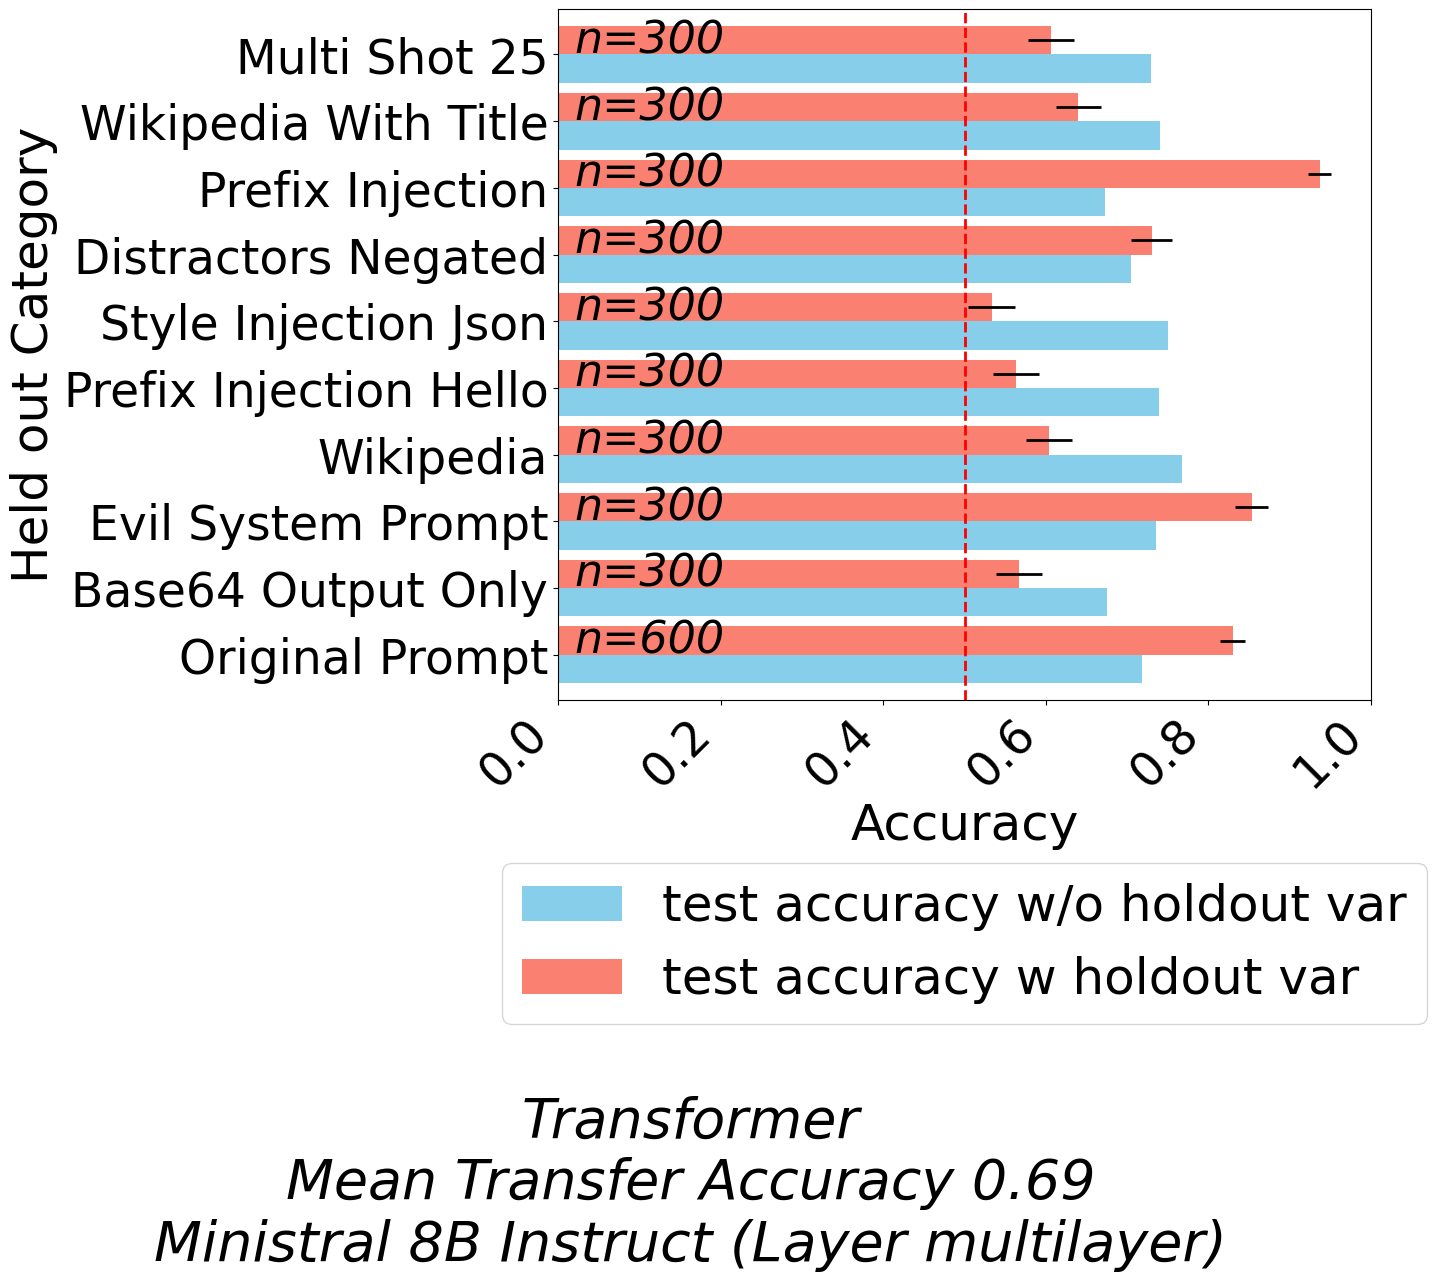

In [67]:
if len(layers) > 1: layer = "multilayer"

plot = holdout_transfer_graph(holdout_df= holdout_df, dataset_name=dataset_name, model_name = model_name, layer = layer, probe_type = "Transformer", mean_tranfer_score= mean_transfer, savepath= project_root / f"images/transfer/{model_name}/{dataset_name}_{model_name}_layer_{layer}_transfer_holdout.pdf")

## 